In [1]:
import numpy as np
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX  

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
fred = Fred(api_key='321467cef92af0c44aa2aaf01257acc5')
cpi = fred.get_series('CPIAUCSL')
inflation = cpi.pct_change(periods = 12) * 100 
inflation.dropna(inplace = True)
inflation_df = pd.DataFrame(inflation, columns=['inflation'])
inflation_df.index.name = 'date'
inflation_df.head(10)                                                                                                                                                                                                                                                   

C:\Users\nitin\AppData\Local\Temp\ipykernel_1596\3683001085.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inflation = cpi.pct_change(periods = 12) * 100


,inflation
date,
1948-01-01,10.242086
1948-02-01,9.481961
1948-03-01,6.818182
1948-04-01,8.272727
1948-05-01,9.384966
1948-06-01,9.375000
1948-07-01,9.761583
1948-08-01,9.062500
1948-09-01,6.654991


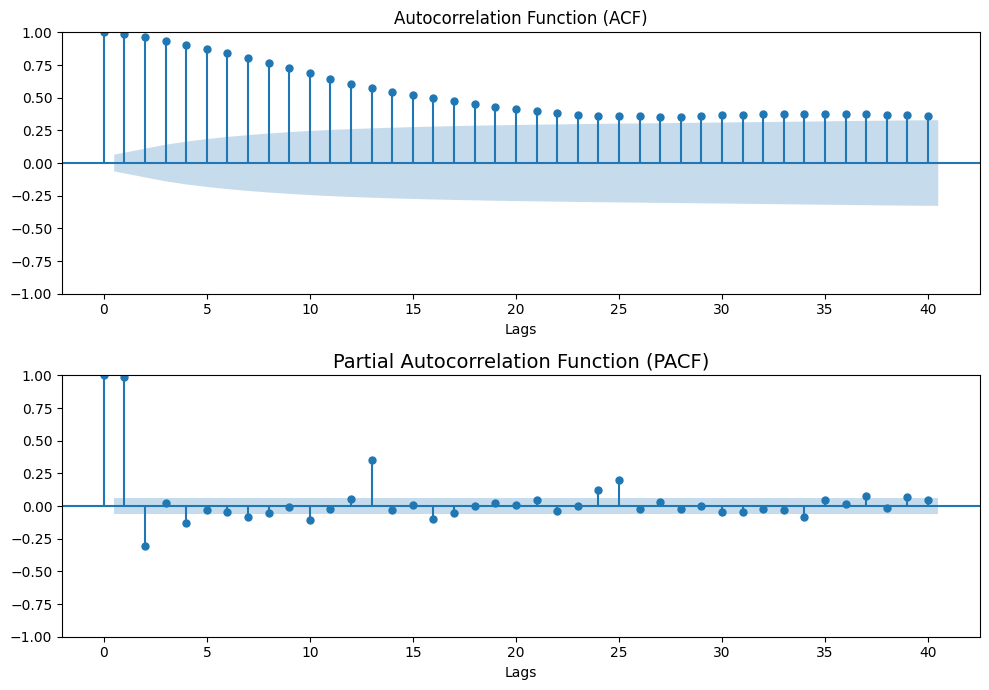

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))

plot_acf(inflation_df['inflation'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lags')

plot_pacf(inflation_df['inflation'], lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
axes[1].set_xlabel('Lags')

plt.tight_layout()
plt.show()

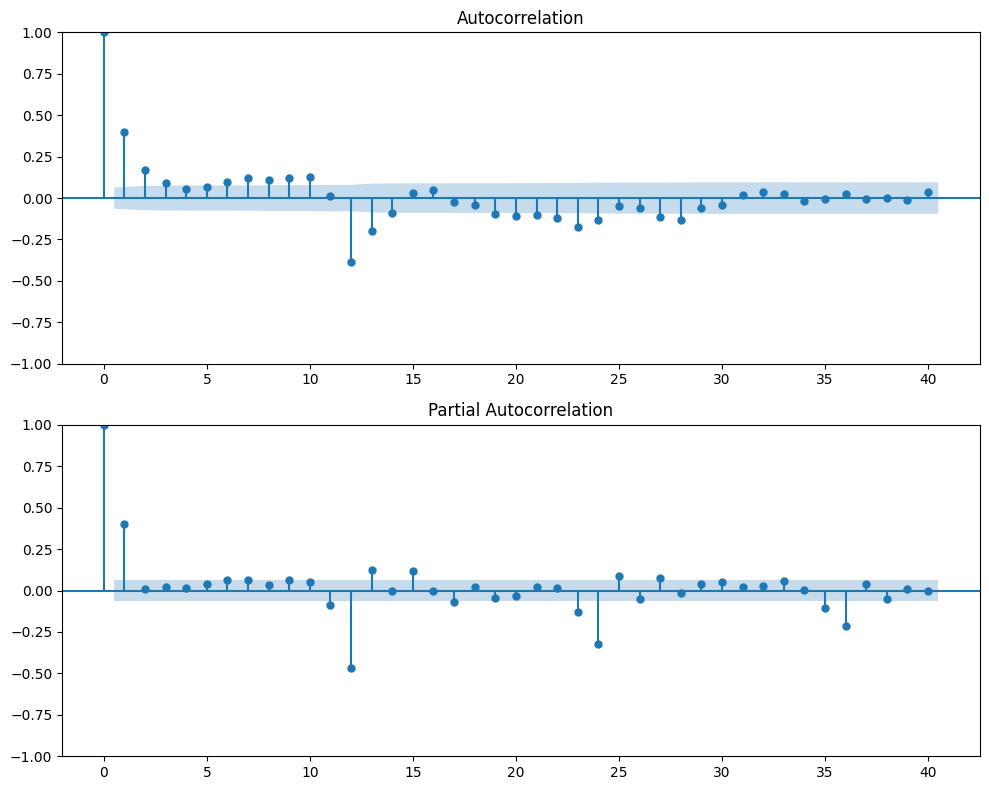

In [4]:
inflation_diff = inflation_df['inflation'].diff().dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(inflation_diff, lags=40, ax=axes[0])
plot_pacf(inflation_diff, lags=40, ax=axes[1])
plt.tight_layout()
plt.show()

In [5]:
train_size = int(len(inflation_df) * 0.8)
train = inflation_df['inflation'][:train_size]
test = inflation_df['inflation'][train_size:] 

In [6]:
model = SARIMAX(train, order = (1,1,1), seasonal_order = (2,1,1,12))
fit = model.fit(disp = False)


c:\Users\nitin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nitin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


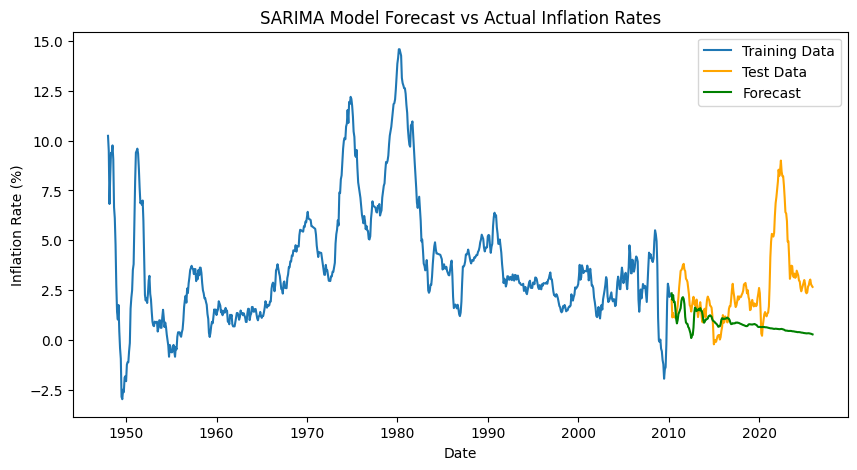

In [7]:
forecast = fit.forecast(steps=len(test))    

plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')     
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('SARIMA Model Forecast vs Actual Inflation Rates')    
plt.legend()
plt.show()

In [8]:
oil = fred.get_series('DCOILWTICO') 
unemployment = fred.get_series('UNRATE')    
m2 = fred.get_series('M2SL')
exo_df = pd.DataFrame({'oil': oil, 'unemployment': unemployment, 'm2': m2})
exo_df.index.name = 'date'

In [9]:
inflation_df = inflation_df.resample('ME').last()
exo_df = exo_df.resample('ME').last()   
 
inflation_exo = pd.concat([inflation_df, exo_df], axis=1)
inflation_exo.ffill(inplace=True)
inflation_exo.dropna(inplace=True)
inflation_exo.head(10)

,inflation,oil,unemployment,m2
date,,,,
1986-01-31,3.973510,18.95,6.7,2502.1
1986-02-28,3.198495,13.23,7.2,2512.9
1986-03-31,2.153558,10.25,7.2,2533.1
1986-04-30,1.588785,13.38,7.1,2557.8
1986-05-31,1.679104,14.30,7.2,2584.8
1986-06-30,1.767442,12.80,7.2,2605.0
1986-07-31,1.671309,11.23,7.0,2626.6
1986-08-31,1.575533,15.93,6.9,2646.5
1986-09-30,1.757632,14.70,7.0,2667.8


In [10]:
adf_oil = adfuller(inflation_exo['oil'])
print(f'ADF Statistic for oil: {adf_oil[0]}')
print(f'p-value for oil: {adf_oil[1]}\n')

adf_unemployment = adfuller(inflation_exo['unemployment'])
print(f'ADF Statistic for unemployment: {adf_unemployment[0]}')
print(f'p-value for unemployment: {adf_unemployment[1]}\n')

adf_m2 = adfuller(inflation_exo['m2'])
print(f'ADF Statistic for m2: {adf_m2[0]}')
print(f'p-value for m2: {adf_m2[1]}')

ADF Statistic for oil: -2.489628227144175
p-value for oil: 0.11801832733220341

ADF Statistic for unemployment: -2.9172362485597683
p-value for unemployment: 0.04338005693508992

ADF Statistic for m2: 1.5277388263422231
p-value for m2: 0.9976237466147859


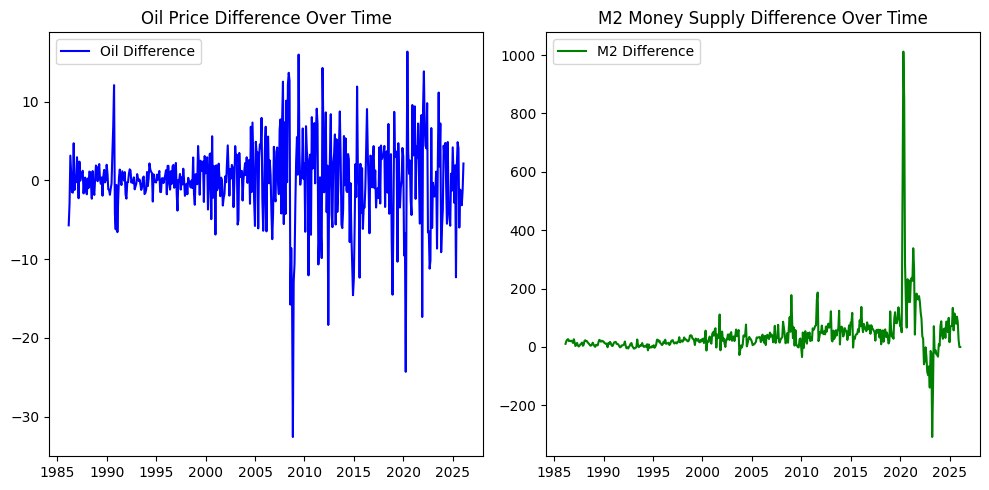

In [11]:
inflation_exo['oil_diff'] = inflation_exo['oil'].diff() 
inflation_exo['m2_diff'] = inflation_exo['m2'].diff()
inflation_exo.dropna(inplace=True)  

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(inflation_exo['oil_diff'], label = 'Oil Difference', color='blue') 
ax[0].set_title('Oil Price Difference Over Time')
ax[0].legend()

ax[1].plot(inflation_exo['m2_diff'], label = 'M2 Difference', color='green')
ax[1].set_title('M2 Money Supply Difference Over Time')
ax[1].legend()

plt.tight_layout()
plt.show()


In [12]:
adf_oil_diff = adfuller(inflation_exo['oil_diff'])
print(f'ADF Statistic for oil difference: {adf_oil_diff[0]}')
print(f'p-value for oil difference: {adf_oil_diff[1]}\n')

adf_m2_diff = adfuller(inflation_exo['m2_diff'])
print(f'ADF Statistic for m2 difference: {adf_m2_diff[0]}') 
print(f'p-value for m2 difference: {adf_m2_diff[1]}')   

ADF Statistic for oil difference: -17.98596939341546
p-value for oil difference: 2.7646189728888403e-30

ADF Statistic for m2 difference: -4.028361302927492
p-value for m2 difference: 0.0012690715499228816


In [13]:
train_size = int(len(inflation_exo)*0.8)
train_exo = inflation_exo.iloc[:train_size]
test_exo = inflation_exo.iloc[train_size:]

In [14]:
model_exo = SARIMAX(train_exo['inflation'], exog = train_exo[['oil_diff', 'unemployment', 'm2_diff']], order=(1,1,1), seasonal_order=(2,1,1,12), )
fit_exo = model_exo.fit(disp=False)
print(fit_exo.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          inflation   No. Observations:                  384
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -79.304
Date:                            Tue, 20 Jan 2026   AIC                            176.609
Time:                                    20:02:50   BIC                            211.854
Sample:                                02-28-1986   HQIC                           190.607
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
oil_diff        -0.0030      0.002     -1.893      0.058      -0.006       0.000
unemployment     0.0578      

c:\Users\nitin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


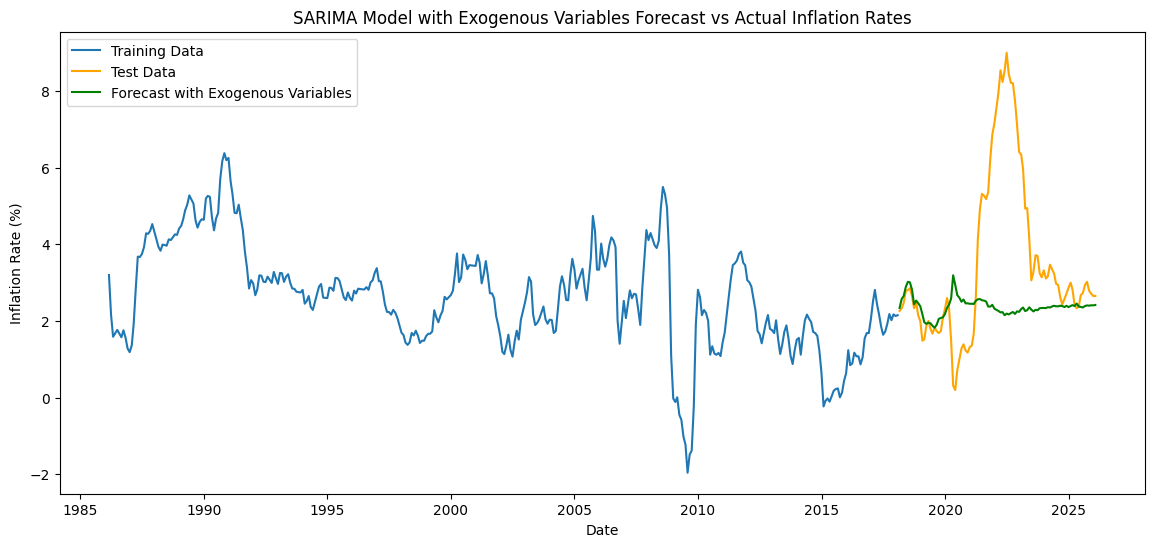

In [15]:
forecast_exo = fit_exo.forecast(steps = len(test_exo), exog = test_exo[['oil_diff', 'unemployment', 'm2_diff']])

plt.figure(figsize=(14, 6))
plt.plot(train_exo.index, train_exo['inflation'], label='Training Data')
plt.plot(test_exo.index, test_exo['inflation'], label='Test Data', color='orange')
plt.plot(test_exo.index, forecast_exo, label='Forecast with Exogenous Variables', color='green')
plt.xlabel('Date')  
plt.ylabel('Inflation Rate (%)')
plt.title('SARIMA Model with Exogenous Variables Forecast vs Actual Inflation Rates')
plt.legend()
plt.show()